In [1]:
# Load width function and Molecular Dynamics results
import sys
from pathlib import Path
from typing import Final

import numpy as np

sys.path.append(str(Path.cwd().parent / "scripts"))

from utils.io import read_gamma_data, read_md_data

from sqw.consts import PI

DATA_DIR: Final[Path] = Path.cwd().parent / "data"

GAMMA_FILENAME: Final[str] = "hydrogen_293k_gamma.h5"
MD_FILENAME: Final[str] = "h2o_293k_all.h5"

GAMMA_KEYS: Final[list[str]] = ["time_vec", "gamma_qtm_real", "gamma_qtm_imag", "gamma_cls"]
MD_KEYS: Final[list[str]] = ["qVec_H", "inc_omega_H", "inc_sqw_H"]

TEMPERATURE: Final[float] = 293.0  # Kelvin

time, gamma_qtm, gamma_cls = read_gamma_data(
    str(DATA_DIR / GAMMA_FILENAME), GAMMA_KEYS, no_extend=False, include_cls=True
)
assert gamma_cls is not None

q_vals, omega_md, raw_sqw_md_stack = read_md_data(str(DATA_DIR / MD_FILENAME), MD_KEYS, no_extend=False)
sqw_md_stack = raw_sqw_md_stack * np.sqrt(2 * PI)

Reading width function data from file '/workspaces/h2o-sqw-calc/data/hydrogen_293k_gamma.h5'...
Width function data read completed.
Reading MD S(q,w) data from file '/workspaces/h2o-sqw-calc/data/h2o_293k_all.h5'...
MD S(q,w) data read completed.


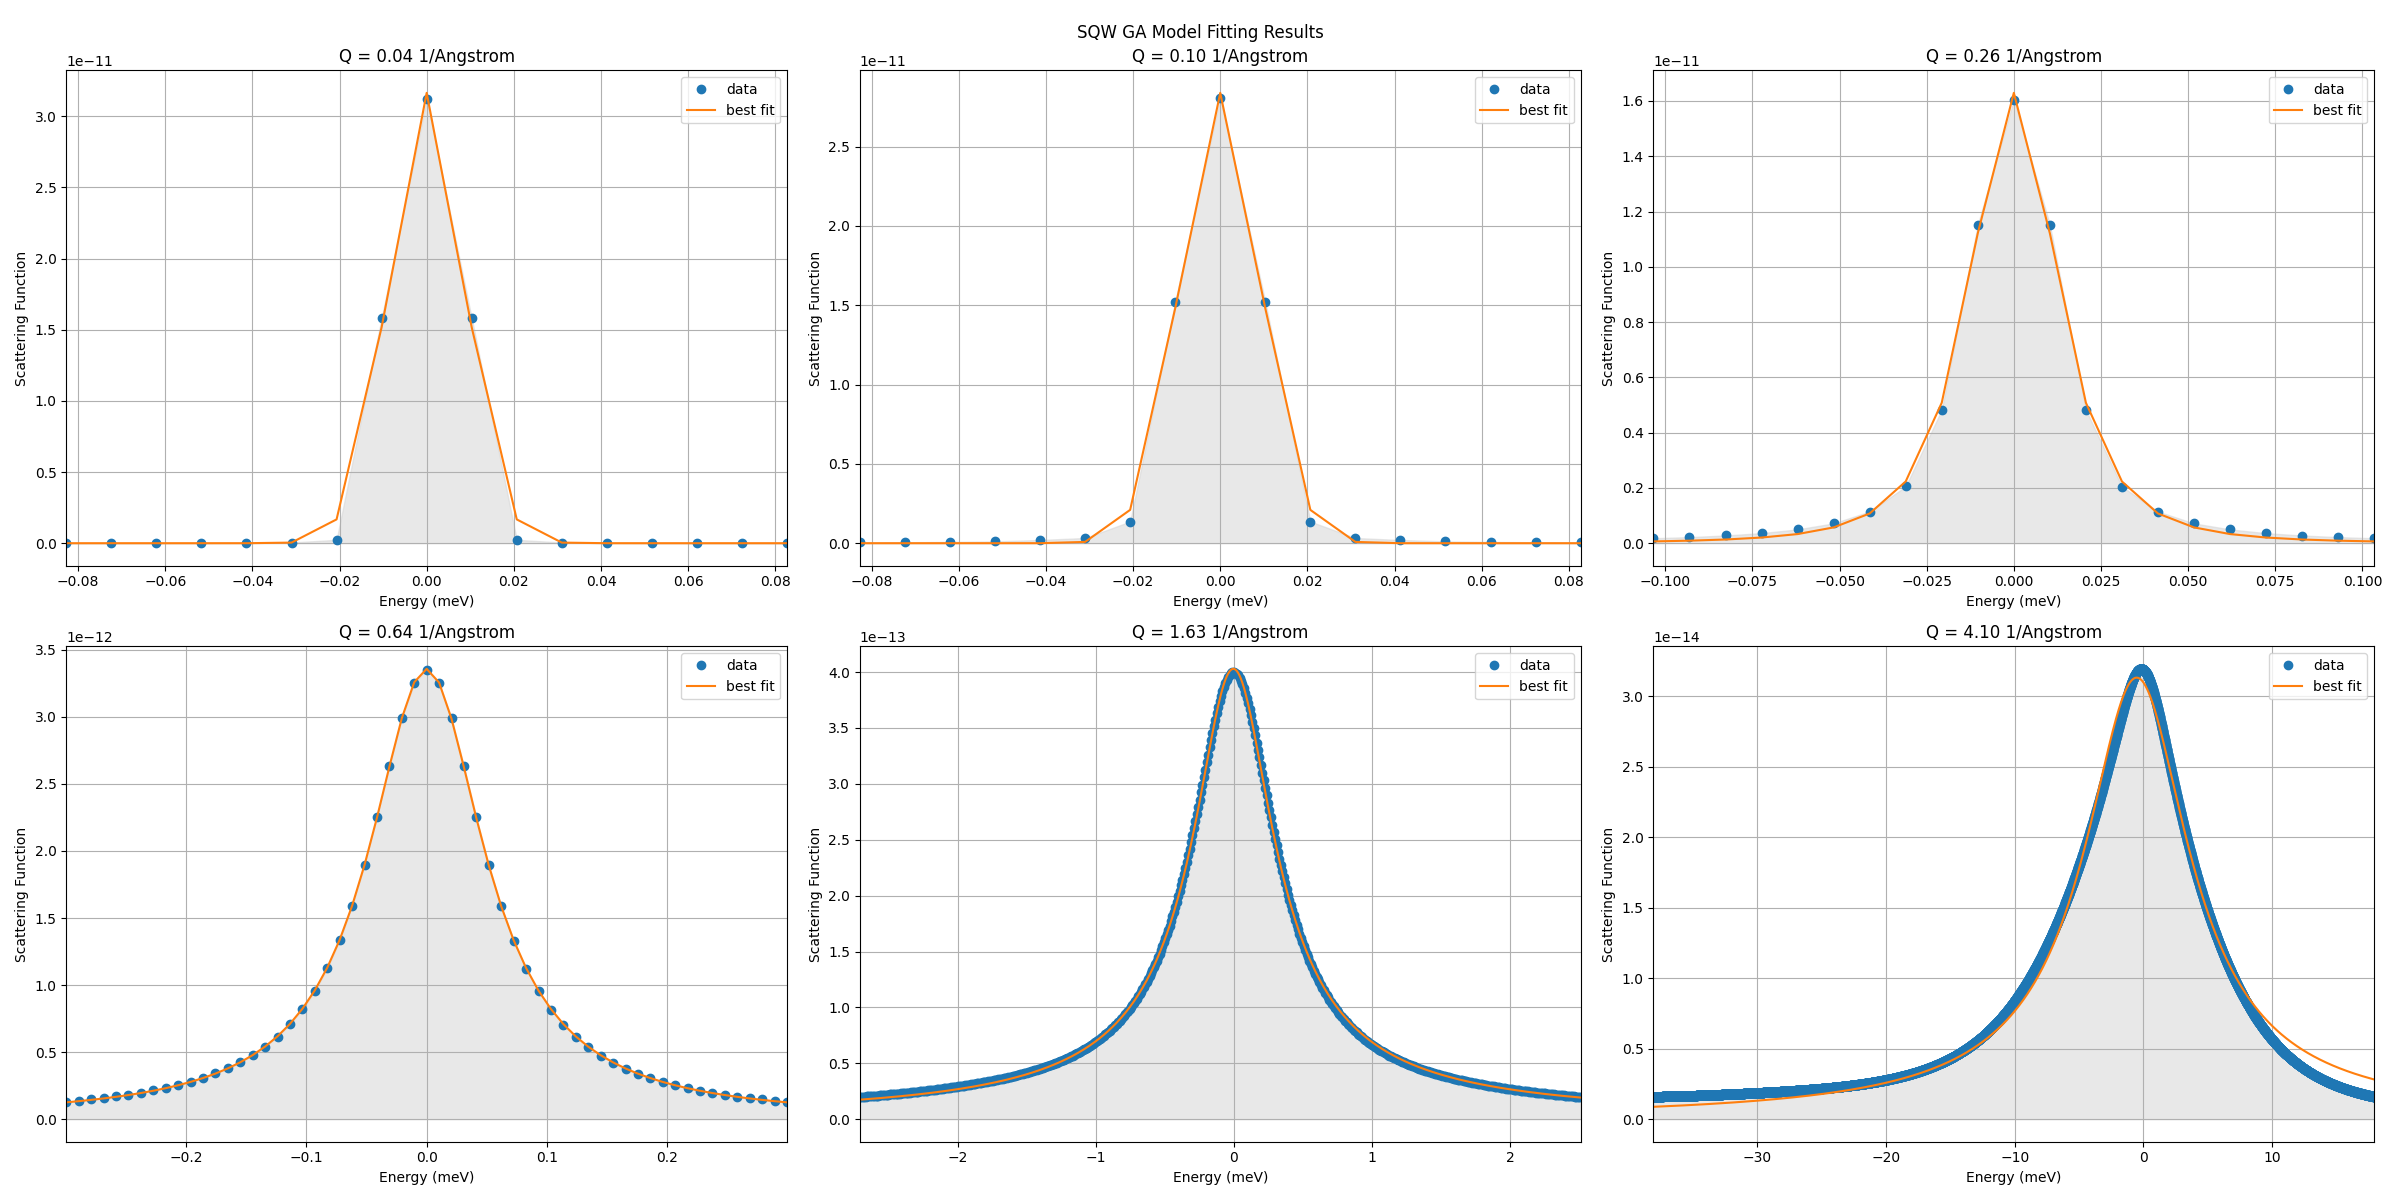

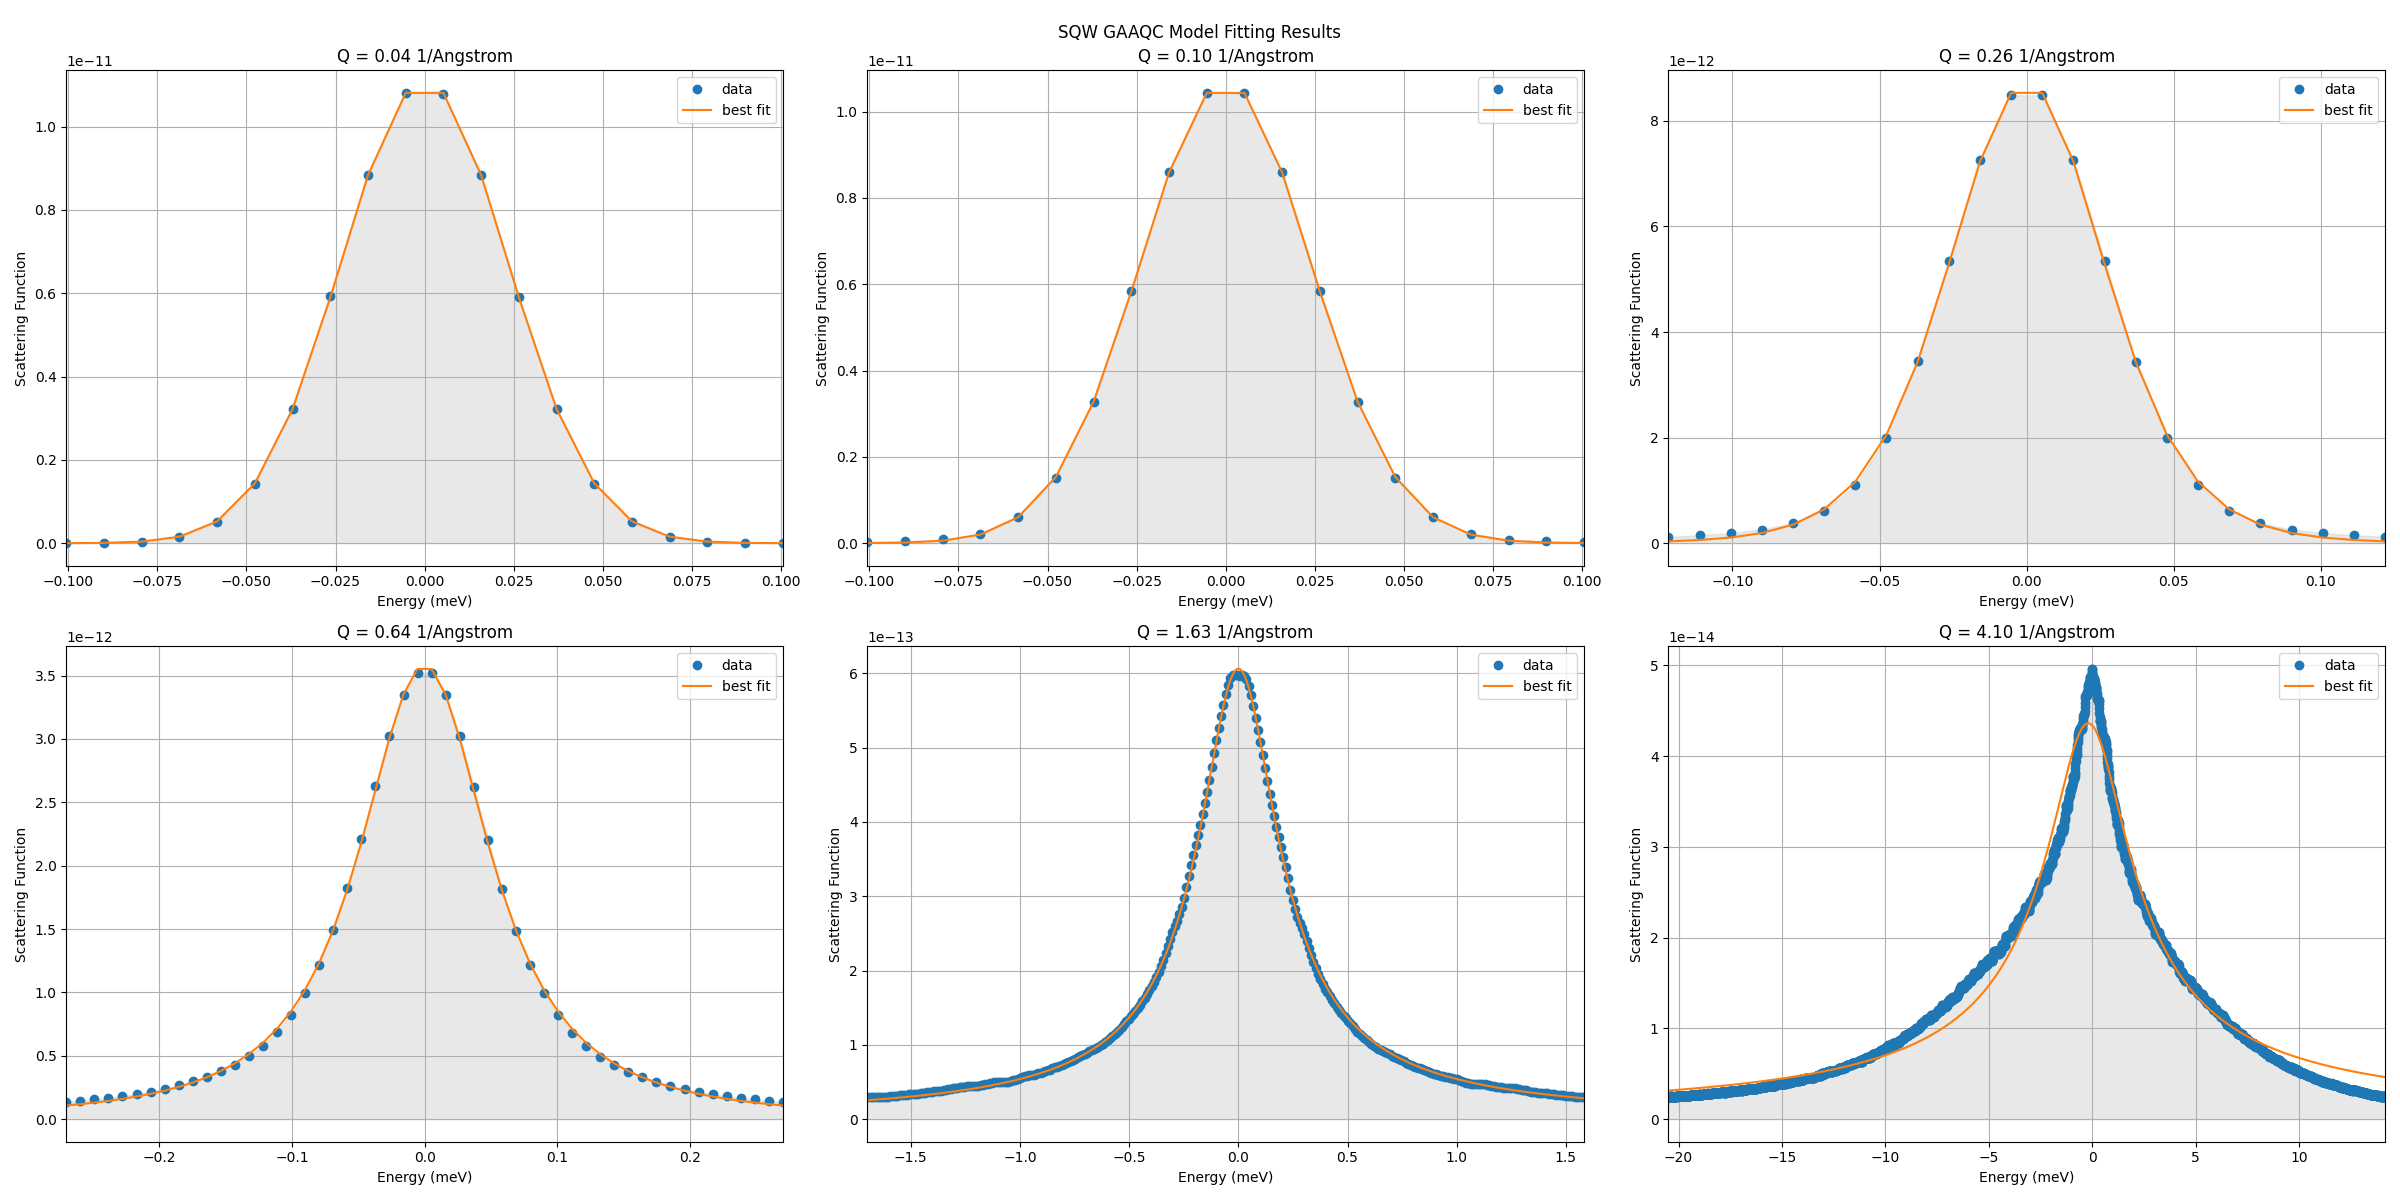

In [2]:
%matplotlib widget
from functools import partial

from lmfit.models import Model, MoffatModel
from matplotlib import pyplot as plt
from scipy import constants
from scipy.ndimage import gaussian_filter1d
from utils.helper import assure_detailed_balance

from sqw._core import sqw_ga_model, sqw_gaaqc_model
from sqw.consts import HBAR
from sqw.typing import Array1D

assure_db = partial(assure_detailed_balance, temperature=293.0)

Q_IDX_TO_FIT = [30, 50, 70, 90, 110, 130]


def find_peak(data: Array1D[np.floating], sigma: int = 3, threshold: float = 0.05) -> Array1D[np.bool]:
    data_smoothed = gaussian_filter1d(data, sigma=sigma)
    peak_idx = np.argmax(data_smoothed)
    peak_value = data_smoothed[peak_idx]

    left_below = np.where(data_smoothed[:peak_idx] < threshold * peak_value)[0]
    right_below = np.where(data_smoothed[peak_idx + 1 :] < threshold * peak_value)[0] + peak_idx + 1

    left_bound = left_below[-1] if left_below.size > 0 else 0
    right_bound = right_below[0] if right_below.size > 0 else data.size - 1

    peak_region = np.zeros_like(data, dtype=bool)
    peak_region[left_bound : right_bound + 1] = True

    return peak_region


def plot_fitting_results(data: list[tuple[Array1D[np.floating], Array1D[np.floating]]], model: Model, ncol: int = 3):
    nrow = (len(data) + ncol - 1) // ncol
    fig, axes = plt.subplots(nrow, ncol, figsize=(8 * ncol, 6 * nrow))
    for i, ((omega, sqw), ax) in enumerate(zip(data, axes.flatten(), strict=True)):
        energy = HBAR * omega / constants.milli  # in meV
        peak_region = find_peak(sqw)

        params = model.guess(sqw[peak_region], x=energy[peak_region])
        fit_result = model.fit(sqw[peak_region], params, x=energy[peak_region])

        fit_result.plot_fit(
            ax=ax,
            title=f"Q = {q_vals[Q_IDX_TO_FIT[i]]:.2f} 1/Angstrom",
            xlabel="Energy (meV)",
            ylabel="Scattering Function",
        )
        ax.set_xlim(energy[peak_region][0], energy[peak_region][-1])
        ax.fill_between(
            energy,
            sqw,
            where=peak_region,
            color="lightgray",
            alpha=0.5,
            label="Peak region used for fitting",
        )
        ax.grid()
    return fig


fig_ga = plot_fitting_results(
    [sqw_ga_model(q, time, gamma_qtm, window=True, correction=assure_db, logger=None) for q in q_vals[Q_IDX_TO_FIT]],  # type: ignore
    MoffatModel(),
)
fig_ga.suptitle("SQW GA Model Fitting Results")
fig_ga.tight_layout()

fig_gaaqc = plot_fitting_results(
    [
        sqw_gaaqc_model(q, time, gamma_qtm, gamma_cls, omega_md, sqw_md, window=True, correction=assure_db, logger=None)  # type: ignore
        for q, sqw_md in zip(q_vals[Q_IDX_TO_FIT], sqw_md_stack[Q_IDX_TO_FIT], strict=True)
    ],
    MoffatModel(),
)
fig_gaaqc.suptitle("SQW GAAQC Model Fitting Results")
fig_gaaqc.tight_layout()

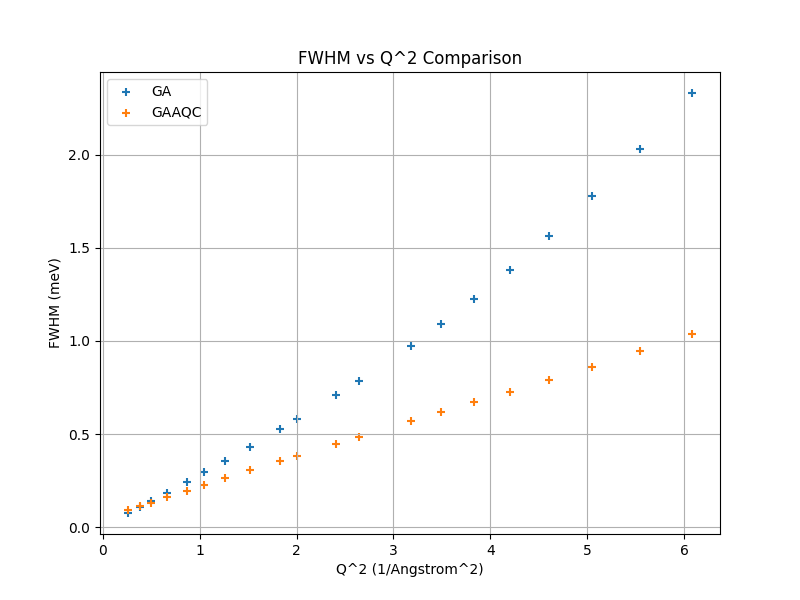

In [3]:
Q_VAL_TO_PLOT = np.linspace(0.5, 2.5, 20)
Q_IDX_TO_PLOT = [np.argmin(np.abs(q_vals - qv)) for qv in Q_VAL_TO_PLOT]


def get_hwhm(omega, sqw):
    peak_region = find_peak(sqw)
    model = MoffatModel()
    params = model.guess(sqw[peak_region], x=omega[peak_region])
    fit_result = model.fit(sqw[peak_region], params, x=omega[peak_region])

    sigma = fit_result.params["sigma"].value
    beta = fit_result.params["beta"].value
    return sigma * np.sqrt(2 ** (1 / max(1e-3, beta)) - 1)


hwhm_ga = np.array(
    [
        get_hwhm(omega, sqw)
        for omega, sqw in [
            sqw_ga_model(q, time, gamma_qtm, window=True, correction=assure_db, logger=None)
            for q in q_vals[Q_IDX_TO_PLOT]
        ]
    ]
)
hwhm_gaaqc = np.array(
    [
        get_hwhm(omega, sqw)
        for omega, sqw in [
            sqw_gaaqc_model(
                q, time, gamma_qtm, gamma_cls, omega_md, sqw_md, window=True, correction=assure_db, logger=None
            )
            for q, sqw_md in zip(q_vals[Q_IDX_TO_PLOT], sqw_md_stack[Q_IDX_TO_PLOT], strict=True)
        ]
    ]
)

plt.figure(figsize=(8, 6))
plt.scatter(q_vals[Q_IDX_TO_PLOT] ** 2, 2 * hwhm_ga * HBAR / constants.milli, label="GA", marker="+")
plt.scatter(q_vals[Q_IDX_TO_PLOT] ** 2, 2 * hwhm_gaaqc * HBAR / constants.milli, label="GAAQC", marker="+")
plt.xlabel("Q^2 (1/Angstrom^2)")
plt.ylabel("FWHM (meV)")
plt.title("FWHM vs Q^2 Comparison")
plt.legend()
plt.grid()